In [2]:
import numpy as np
from numpy.random import default_rng
import time
from datetime import datetime
import matplotlib.pyplot as plt
import taichi as ti

## Macros and flags
ROOT = './data/'
STOCHASTIC_SAMPLING = 0

## Simulation-wide constants
N_AGENTS = 1000000
DOMAIN_SCALE = 100.0
TRACE_RESOLUTION = (1024, 1024)
DEPOSIT_DOWNSCALING_FACTOR = 4

DEPOSIT_RESOLUTION = (TRACE_RESOLUTION[0] // DEPOSIT_DOWNSCALING_FACTOR, TRACE_RESOLUTION[1] // DEPOSIT_DOWNSCALING_FACTOR)
DOMAIN_SIZE = (DOMAIN_SCALE, DOMAIN_SCALE * np.float32(TRACE_RESOLUTION[1]) / np.float32(TRACE_RESOLUTION[0]))
VIS_RESOLUTION = TRACE_RESOLUTION

## Type aliases
FLOAT_CPU = np.float32
INT_CPU = np.int32
FLOAT_GPU = ti.f32
INT_GPU = ti.i32

VEC2i = ti.types.vector(2, INT_GPU)
VEC3i = ti.types.vector(2, INT_GPU)
VEC2f = ti.types.vector(2, FLOAT_GPU)
VEC3f = ti.types.vector(3, FLOAT_GPU)

## Initializations
ti.init(arch=ti.cpu)
rng = default_rng()

print('Number of agents:', N_AGENTS)
print('Trace grid resolution:', TRACE_RESOLUTION)
print('Deposit grid resolution:', DEPOSIT_RESOLUTION)
print('Simulation domain size:', DOMAIN_SIZE)

[Taichi] version 1.0.0, llvm 10.0.0, commit 6a15da85, win, python 3.8.8
[Taichi] Starting on arch=x64
Number of agents: 1000000
Trace grid resolution: (1024, 1024)
Deposit grid resolution: (256, 256)
Simulation domain size: (100.0, 100.0)


In [3]:
## Initialize agents randomly (later around data)
agents = np.zeros(shape=(N_AGENTS, 4), dtype=FLOAT_CPU)
agents[:, 0] = rng.uniform(low=0.0, high=DOMAIN_SIZE[0], size=agents.shape[0])
agents[:, 1] = rng.uniform(low=0.0, high=DOMAIN_SIZE[1], size=agents.shape[0])
agents[:, 2] = rng.uniform(low=0.0, high=2.0*np.pi, size=agents.shape[0])
agents[:, 3] = 1.0
print(agents[0, :])

[89.21127   72.4564     5.4603376  1.       ]


In [4]:
## Allocate GPU memory fields
agents_field = ti.Vector.field(n=4, dtype=FLOAT_GPU, shape=N_AGENTS)
deposit_field = ti.Vector.field(n=2, dtype=FLOAT_GPU, shape=DEPOSIT_RESOLUTION)
trace_field = ti.Vector.field(n=1, dtype=FLOAT_GPU, shape=TRACE_RESOLUTION)
vis_field = ti.Vector.field(n=3, dtype=FLOAT_GPU, shape=VIS_RESOLUTION)

In [5]:
## Define all GPU kernels and functions
@ti.kernel
def zero_field(f: ti.template()):
    for cell in ti.grouped(f):
        f[cell].fill(0.0)
    return

@ti.kernel
def copy_field(dst: ti.template(), src: ti.template()): 
    for cell in ti.grouped(dst):
        dst[cell] = src[cell]
    return

@ti.func
def world_to_grid_2D(pos_world, size_world, size_grid) -> VEC2i:
    return ti.cast((pos_world / size_world) * ti.cast(size_grid, FLOAT_GPU), INT_GPU)

@ti.func
def angle_to_dir_2D(angle) -> VEC2f:
    return VEC2f(ti.cos(angle), ti.sin(angle))

@ti.func
def custom_mod(a, b) -> FLOAT_GPU:
    return a - b * ti.floor(a / b)

@ti.kernel
def propagation_step(sense_distance: FLOAT_GPU, sense_angle: FLOAT_GPU, steering_rate: FLOAT_GPU, step_size: FLOAT_GPU, weight_multiplier: FLOAT_GPU, stochastic_sampling: INT_GPU):
    for agent in ti.ndrange(agents_field.shape[0]):
        pos = VEC2f(0.0, 0.0)
        pos[0], pos[1], angle, weight = agents_field[agent]

        dir_fwd = angle_to_dir_2D(angle)
        angle_mut = angle + (ti.random(dtype=FLOAT_GPU) - 0.5) * sense_angle
        dir_mut = angle_to_dir_2D(angle_mut)

        deposit_fwd = deposit_field[world_to_grid_2D(pos + sense_distance * dir_fwd, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][0]
        deposit_mut = deposit_field[world_to_grid_2D(pos + sense_distance * dir_mut, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][0]
        # random_angle = 360.0 * ti.random(dtype=FLOAT_GPU)
        # pos_fwd = pos + sense_distance * dir_fwd + (10.0 * step_size * ti.random(dtype=FLOAT_GPU) * angle_to_dir_2D(random_angle))
        # deposit_fwd = deposit_field[world_to_grid_2D(pos_fwd, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][0]
        # random_angle = 360.0 * ti.random(dtype=FLOAT_GPU)
        # pos_mut = pos + sense_distance * dir_mut + (10.0 * step_size * ti.random(dtype=FLOAT_GPU) * angle_to_dir_2D(random_angle))
        # deposit_mut = deposit_field[world_to_grid_2D(pos_mut, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))][0]

        angle_new = 0.0
        if stochastic_sampling:
            angle_new = (angle) if (ti.random(dtype=FLOAT_GPU) < deposit_fwd / (deposit_fwd + deposit_mut)) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        else:
            angle_new = (angle) if (deposit_fwd > deposit_mut) else (steering_rate * angle_mut + (1.0-steering_rate) * angle)
        dir_new = angle_to_dir_2D(angle_new)
        pos_new = pos + step_size * dir_new

        pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
        pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

        agents_field[agent][0] = pos_new[0]
        agents_field[agent][1] = pos_new[1]
        agents_field[agent][2] = angle_new

        deposit_cell = world_to_grid_2D(pos_new, VEC2f(DOMAIN_SIZE), VEC2i(DEPOSIT_RESOLUTION))
        deposit_field[deposit_cell][0] += weight_multiplier * weight

        trace_cell = world_to_grid_2D(pos_new, VEC2f(DOMAIN_SIZE), VEC2i(TRACE_RESOLUTION))
        trace_field[trace_cell][0] += weight_multiplier * weight
    return

@ti.kernel
def relaxation_step_deposit(attenuation: FLOAT_GPU):
    for cell in ti.grouped(deposit_field):
        # TODO deposit diffusion
        deposit_field[cell][0] *= attenuation
    return

@ti.kernel
def relaxation_step_trace(attenuation: FLOAT_GPU):
    for cell in ti.grouped(trace_field):
        trace_field[cell][0] *= attenuation
    return

@ti.kernel
def render_visualization():
    for x, y in ti.ndrange(vis_field.shape[0], vis_field.shape[1]):
        deposit_val = deposit_field[x * DEPOSIT_RESOLUTION[0] // VIS_RESOLUTION[0], y * DEPOSIT_RESOLUTION[1] // VIS_RESOLUTION[1]][0]
        trace_val = trace_field[x * TRACE_RESOLUTION[0] // VIS_RESOLUTION[0], y * TRACE_RESOLUTION[1] // VIS_RESOLUTION[1]]
        vis_field[x, y] = VEC3f(trace_val, trace_val, deposit_val if (trace_val < 0.1) else 0.0)
    return

In [6]:
## Initialize GPU fields
agents_field.from_numpy(agents)
zero_field(deposit_field)
zero_field(trace_field)
zero_field(vis_field)

In [7]:
## Main simulation & vis loop
sense_distance = 1.0
sense_angle = 2.5
step_size = 0.1
attenuation = 0.95
weight_multiplier = 0.1
steering_rate = 0.5

window = ti.ui.Window('PolyPhy', (vis_field.shape[0], vis_field.shape[1]), show_window=True)
canvas = window.get_canvas()

while window.running:
    do_quit = False
    if window.get_event(ti.ui.PRESS):
        if window.event.key in [ti.ui.ESCAPE]: do_quit = True
    
    window.GUI.begin('Main', 0.01, 0.01, 0.35, 0.2)
    sense_distance = window.GUI.slider_float('Sense dist', sense_distance, 0.1, 10.0)
    sense_angle = window.GUI.slider_float('Sense angle', sense_angle, 0.1, 10.0)
    step_size = window.GUI.slider_float('Step size', step_size, 0.01, 0.5)
    attenuation = window.GUI.slider_float('Attenuation', attenuation, 0.9, 0.999)
    weight_multiplier = window.GUI.slider_float('Weight coef', weight_multiplier, 0.001, 1.0)
    do_screenshot = window.GUI.button('Screenshot')
    do_quit = do_quit | window.GUI.button('Quit')
    window.GUI.end()

    propagation_step(sense_distance, sense_angle, steering_rate, step_size, weight_multiplier, STOCHASTIC_SAMPLING)
    relaxation_step_deposit(attenuation)
    relaxation_step_trace(attenuation)

    render_visualization()
    canvas.set_image(vis_field)

    if do_screenshot:
        window.write_image(ROOT + 'capture/screenshot_' + datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d_%H-%M-%S") + '.png')
        take_screenshot = False
    window.show()
    if do_quit:
        break

window.destroy()
deposit = deposit_field.to_numpy()
trace = trace_field.to_numpy()

In [8]:
deposit.shape

(256, 256, 2)

In [9]:
trace.shape

(1024, 1024, 1)

In [10]:
import numpy as np
np.unique(trace)

array([0.0000000e+00, 5.1046819e-03, 5.3733494e-03, ..., 1.4442095e+01,
       1.4607637e+01, 1.5376680e+01], dtype=float32)

In [10]:
import matplotlib.pyplot as plt

In [22]:
np.save('deposit.npy', deposit)

In [19]:
# plt.imshow(trace)
from PIL import Image
im = deposit[:,:,0]
_min = np.amin(im)
_max = np.amax(im)
im = (im - _min) * 255.0 / (_max - _min)
im = Image.fromarray(im)
im = im.convert("L")
im.save("deposit.png")

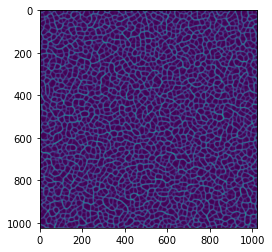

In [23]:
new = Image.open('trace.png')
plt.imshow(new)

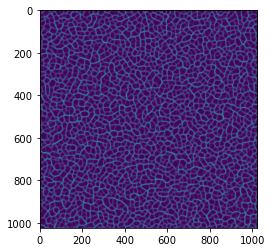

In [24]:
plt.imshow(trace[:,:,0])

In [ ]:
## Plot results
plt.figure(figsize = (10.0, 10.0))
plt.imshow(deposit[:,:,0])
plt.figure(figsize = (10.0, 10.0))
plt.imshow(trace)